<a href="https://colab.research.google.com/github/SophieMargolis/Advanced_ML_DL_Course_Assignment_1/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Assignment 1**<br>
## By: Raz Graider, Sophie Margolis and Dana Braynin

## **Introduction**

In this project, we were given information about the number of bicycles that were rented in each day.<br>
We were asked to build 3 models that predict how many bicycles were rented in each day and compare between the models.<br>
This project is a regression problem. We were given 8,164 observations. We will analyze the given data, process it and predict the samples in the test data.

##**Import libraries**

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
import os


# models:
import xgboost as xg
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

##**Loading the data**

In [ ]:
def load_files():
  '''
  output: df (the train data), test (the test data)
  '''
  # Load train data
  df = pd.read_csv('https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20I/train.csv')

  # Load test data
  test = pd.read_csv('https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20I/test.csv')

  return df, test

In [ ]:
df, test = load_files()

##**Exploring the data**

### General Information


First, we want to get information about the data types and the number of non-null values in each column (this will help us understand if there are any missing null values).

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8164 entries, 0 to 8163
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    8164 non-null   object 
 1   season      8164 non-null   int64  
 2   holiday     8164 non-null   int64  
 3   workingday  8164 non-null   int64  
 4   weather     8164 non-null   int64  
 5   temp        8164 non-null   float64
 6   atemp       8164 non-null   float64
 7   humidity    8164 non-null   int64  
 8   windspeed   8164 non-null   float64
 9   pollution   8164 non-null   float64
 10  sunlight    8164 non-null   float64
 11  traffic     8164 non-null   float64
 12  count       8164 non-null   int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 829.3+ KB


This method shows us that we have 3 types of variables we need to take into considiration: object, int and float.<br>
Also, we learn that we don't have any null values (each feature has 8164 non-null samples and we have a total of 8164 samples).

Let's look at statistical attributes of our data:

In [ ]:
df.describe().round(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,count
count,8164.000,8164.000,8164.000,8164.000,8164.000,8164.000,8164.000,8164.000,8164.000,8164.000,8164.000,8164.000
mean,2.510,0.029,0.683,1.415,20.245,23.670,61.835,12.791,47.152,20.246,0.005,191.340
std,1.117,0.169,0.465,0.631,7.796,8.469,19.256,8.214,72.883,7.796,0.006,181.143
min,1.000,0.000,0.000,1.000,0.820,0.760,0.000,0.000,0.000,0.821,0.000,1.000
25%,2.000,0.000,0.000,1.000,13.940,16.665,47.000,7.002,3.693,13.941,0.000,41.000
50%,3.000,0.000,1.000,1.000,20.500,24.240,62.000,12.998,17.684,20.501,0.000,145.000
75%,4.000,0.000,1.000,2.000,26.240,31.060,77.000,16.998,59.258,26.241,0.004,285.000
max,4.000,1.000,1.000,4.000,41.000,45.455,100.000,56.997,754.305,41.001,0.016,970.000


We can gain basic insights into various aspects, including the mean value of the label `count`, which represents the number of bicycle rentals and is 191. The maximum value is 970, and the minimum value is 1, indicating a large variance. Examining the minimum and maximum values of features helps us understand feature scaling and the spread (std) of the data.<br> Additionally, we can observe that there are no negative values in our dataset.

### Displaying the features using graphs


We will divide the features into groups according to their type:<br>
According to the data documentation, the features `holiday` and `working day` are binary.<br>
Also, it is written in the documentation that the features `weather` and `season` are represented by *int* but these numbers represent groups, so the features are nominal categorical features.

In [ ]:
# Define a list named 'object_features' containing the column name 'datetime'
object_features = ['datetime']

# Identifie binary features in the DataFrame 'df'
binary_features = df.select_dtypes(['float64','int64']).columns[df.select_dtypes(['float64','int64']).nunique() <= 2].tolist()

# Define a list named 'nominal_categorical_features' containing the column names 'weather' and 'season'
nominal_categorical_features = ['weather', 'season']

# Identifie continuous features in the DataFrame 'df'
continuous_features = df.select_dtypes(['float64','int64']).columns[df.select_dtypes(['float64','int64']).nunique() > 2].tolist()

# Remove nominal features from the continuous_features list
continuous_features = [feature for feature in continuous_features if feature not in nominal_categorical_features]

print("The object features is:\n", object_features)
print("\nThe binary features are:\n", binary_features)
print("\nThe nominal categorical features are:\n",nominal_categorical_features)
print("\nThe continuous features are:\n",continuous_features)

The object features is:
 ['datetime']

The binary features are:
 ['holiday', 'workingday']

The nominal categorical features are:
 ['weather', 'season']

The continuous features are:
 ['temp', 'atemp', 'humidity', 'windspeed', 'pollution', 'sunlight', 'traffic', 'count']



We will present the continuous features using a histogram:

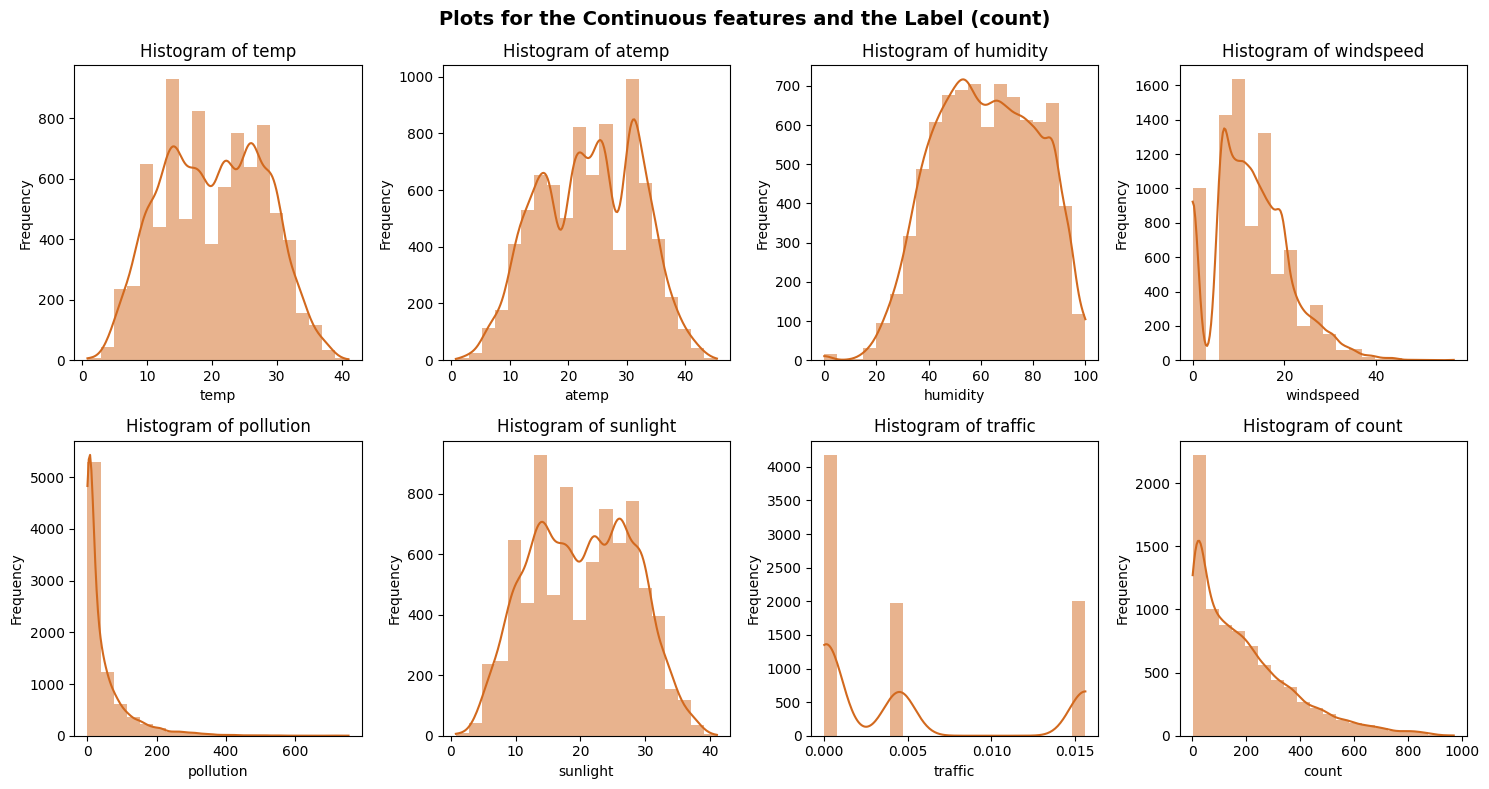

In [ ]:
# Create a figure and an array of subplots with 2 rows and 4 columns. The size of the figure is set to (15, 8) inches
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
# Flatten the 2D array of subplots into a 1D array
axes = axes.flatten()

for i, feature in enumerate(continuous_features):
    # select the subplot corresponding to the current index i
    ax = axes[i]
    # Create a histogram plot of the current feature
    sns.histplot(df[feature], ax=ax, bins=20, edgecolor='none', kde=True, kde_kws={'bw_method': 0.15}, color='chocolate')
    # Set labels of x-axis, y-axis and title
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram of {}'.format(feature))

# Set the title for the entire figure
plt.suptitle("Plots for the Continuous features and the Label (count)", fontsize=14, fontweight='bold')

# Adjust the layout of the subplots to prevent overlapping
plt.tight_layout()
# Display the figure
plt.show()


We can observe from the plot that:

*   The `sunlight` and `temp` features share the same histogram.
*   The majority of continuous features display skewness or non-bell-shaped distributions, except for `humidity`, which appears closer to a normal distribution.
*   We observe outliers in the `windspeed` and `pollution` features; later, we will consider how to handle them.








We will present the binary features using a countplot:

In [ ]:
def binary_and_nominal_categorical_plots(features, palette, feature_type):
  '''
  input: features (the features we want to plot),
         palette (the colors to use),
         feature_type (the name of the feature)
  output: plot
  '''
  # Create a figure and an array of subplots with 1 row and 2 columns. The size of the figure is set to (10, 1 * 4) inches
  fig, axes = plt.subplots(1, 2, figsize=(10, 1 * 4))
  # Flatten the 2D array of subplots into a 1D array
  axes = axes.flatten()

  for i, feature in enumerate(features):
      # Select the subplot corresponding to the current index i
      ax = axes[i]
      # Create a countplot of the current feature
      sns.countplot(x=feature, data=df, ax=ax, palette=palette)
      # Set labels of x-axis, y-axis and title
      ax.set_xlabel(feature)
      ax.set_ylabel('Count')
      ax.set_title('Countplot of {}'.format(feature))

      for p in ax.patches:
          # Get the height (count) of the current bar
          height = p.get_height()
          # Add text annotations to each bar in the current subplot
          ax.annotate(f'{int(height)}',
                      (p.get_x() + p.get_width() / 2., height / 2),
                      ha='center', va='center',
                      xytext=(0, 10),
                      textcoords='offset points',
                      fontweight='bold')

  # Set the title for the entire figure
  plt.suptitle("Plots for the {}". format(feature_type), fontsize=14, fontweight='bold')

  # Adjust the layout of the subplots to prevent overlapping
  plt.tight_layout()
  # Display the figure
  plt.show()

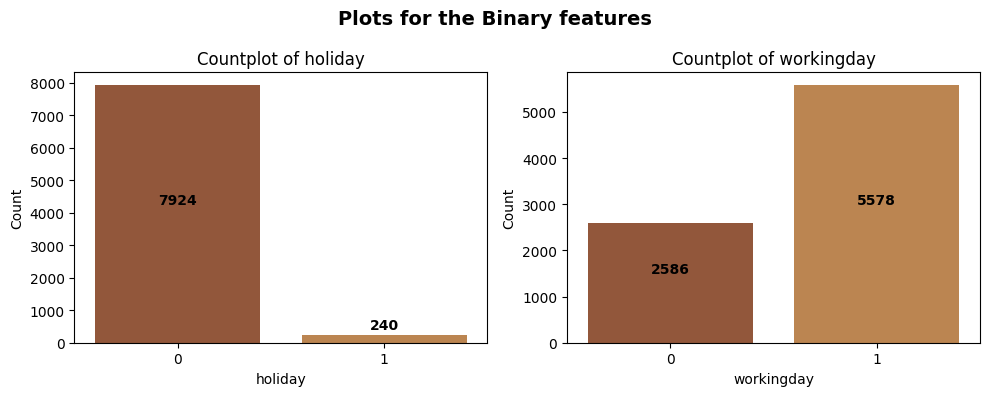

In [ ]:
binary_and_nominal_categorical_plots(binary_features, ["sienna", "peru"], "Binary features")

By looking at the `holiday` plot, we can assume that the majority of the people rent bicycle on not holiday days because they use it for transportation to get to work. This conclusion also arises from the `workingday` plot.

And we will also use countplot to present the nominal categorical features.<br><br>
According to the data documentation the categories are:<br>
`weather`:<br>
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy<br>
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog<br>

`season`:<br>
- 1: winter<br>
- 2: spring<br>
- 3: summer<br>
- 4: fall


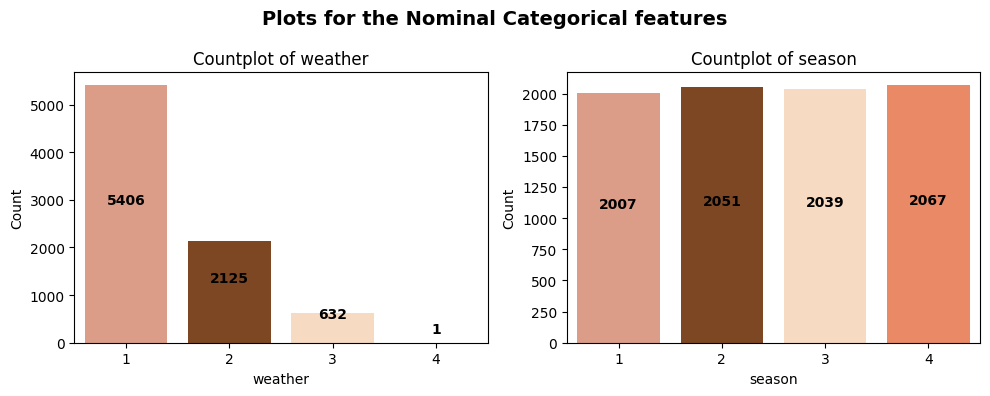

In [ ]:
binary_and_nominal_categorical_plots(nominal_categorical_features, ["darksalmon", "saddlebrown", "peachpuff", "coral"], "Nominal Categorical features")

From the plot, we can see that there are approximately the same numbers of bicycle rentals in every season of the year. What we observe is that the number of bicycle rentals is not significantly affected by the season, but rather by the weather on a specific day within a season.

It makes sense that we see larger numbers of rentals on clear and cloudy days. Additionally, we notice that when the weather conditions are unfavorable for bicycle riding, such as during thunderstorms and rainy days, there was only 1 bicycle rental.

### Datetime plot

We decided to present the `datetime` feature separately because it is the only feature of type *object* and it contains 2 types of information: date and time.<br>
In the following plot we will present the amount of bicycle rentals in relation to the months:

In [ ]:
def prepare_data_to_plot_datetime(df, info):
  '''
  input: df (the data we want to use),
         info (the name of the feature)
  output:
  '''
  # Convert the 'datetime' column in the df to datetime format
  df['datetime'] = pd.to_datetime(df['datetime'])

  # Handle the transformation of the 'datetime' column based on the value of the variable 'info'
  if info == 'date':
    df[info] = df.datetime.dt.date
    df[info] = pd.to_datetime(df[info])
  else:
    df[info] = df.datetime.dt.hour
    df[info] = df['datetime'].dt.hour

  # Sort DataFrame by info
  df = df.sort_values(by=info)

  # Group by info and calculate the sum of 'count'
  df_sum = df.groupby(info)['count'].sum().reset_index()

  # Format the values in the 'hour' column of the df_sum to include leading zeros and a ':00' suffix
  if info == 'hour':
    df_sum['hour'] = df_sum['hour'].apply(lambda x: f"{x:02d}:00")

  # Plotting a Line Graph
  plt.figure(figsize=(20, 3))
  sns.lineplot(data=df_sum, x=info, y='count', color='sienna')

  # Set labels of x-axis and y-axis
  plt.xlabel(info)
  plt.ylabel('count')

  # Customize the x-axis ticks and plot title based on the value of the variable 'info'
  if info == 'date':
    plt.xticks(df_sum[info].dt.to_period("M").astype(str), rotation=45, ha='right')
    plt.title('Bike Sharing Rental Trends between 01-2011 and 12-2012')
  else:
    plt.xticks(rotation=45, ha='right')
    plt.title('Bike Sharing Rental Trends Over Hours')

  # Set background color
  plt.gca().set_facecolor('seashell')

  # Set Seaborn style with white grid
  sns.set_style("whitegrid")

  # Display the plot
  plt.show()

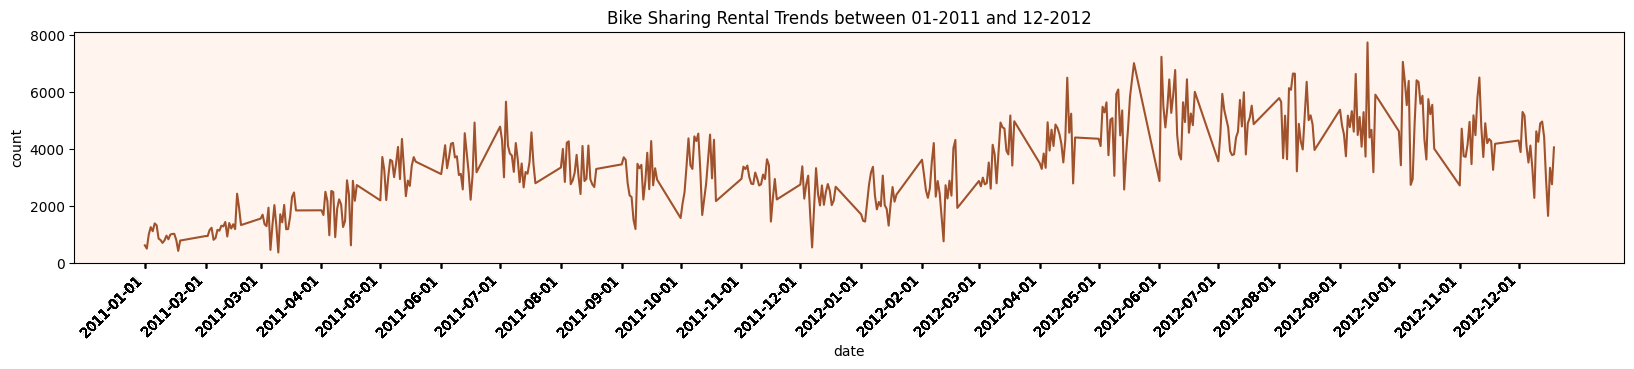

In [ ]:
prepare_data_to_plot_datetime(df, 'date')

* The plot illustrates abrupt and sharp changes along the line graph, leading us to believe that bike rental counts are closely linked to specific weather conditions on a given day. Although these conditions may vary from month to month, we can still assume a seasonal effect.
This is evident when comparing bike rental counts between January-March and May-July for both 2011 and 2012, **where the May-July period shows more bike rentals than the January-March period.** We can assume it's season-related.
* **Since 2012, there has been a noticeable increase in the number of rented bikes.** Several factors could contribute to this trend, such as successful marketing campaigns that heightened awareness of the company, a growing concern for environmental issues and pollution, or even a rise in public transportation fares, among other possibilities we can consider.

In the next plot we will present the amount of bicycle rentals in relation to the hours of the day:

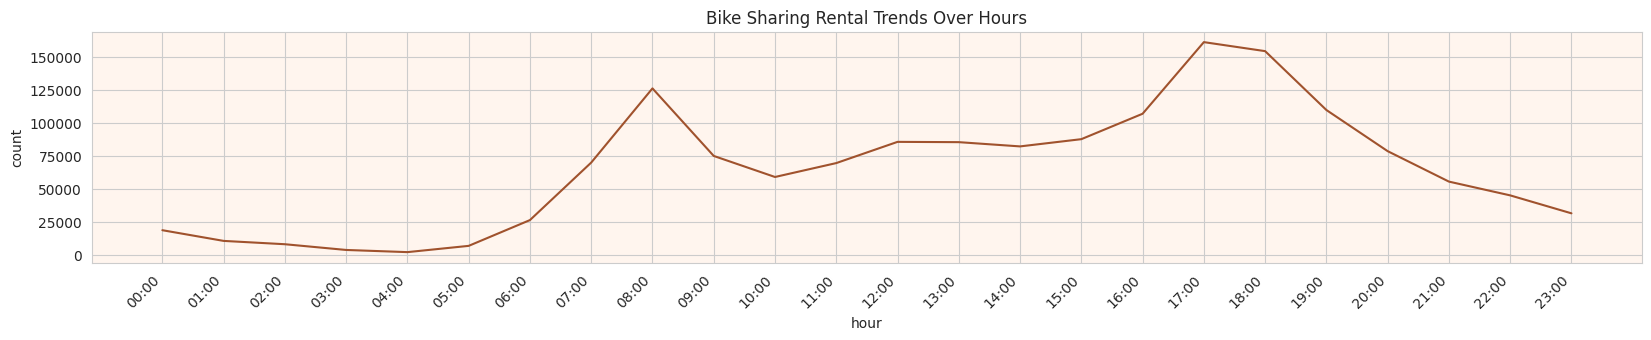

In [ ]:
prepare_data_to_plot_datetime(df, 'hour')

From the plot we can learn that the hours when the most bicycles are rented are in the morning, around 08:00 o'clock, and in the evening, around 18:00 o'clock. This shows that it is likely that people rent bicycles mainly on the way to work or on the way back. This is also connected to the `workingday` and `holiday` plots in which we saw that people mostly  rent bicycles on working days and not on holidays.

In order not to change the data at this stage, we will remove the features we created:

In [ ]:
df = df.drop(columns=['date', 'hour'])

### Correlation matrix

We will show the correlation matrix using matplotlib and seaborn. The matrix measures the strength and direction of a linear relationship between two variables.

In [ ]:
def correlation_matrix(df):
  '''
  input: df (the data we want to use)
  output: plot
  '''
  # Calculate the Pearson correlation coefficients between all pairs in the df
  correlations = df.corr()

  # Create a boolean mask with the same shape as the correlation matrix
  mask = np.zeros_like(correlations, dtype=bool)
  mask[np.triu_indices_from(mask, k=1)] = True

  # Create a new figure and axis object for the heatmap visualization
  fig, ax = plt.subplots(figsize=(12, 12))
  plt.title('Pearson Correlation Heatmap', fontsize=23)

  # Generate a heatmap plot of the correlation matrix
  sns.heatmap(correlations, linewidths=0.25, vmax=1.0, square=True, cmap="copper",
            linecolor='w', annot=True, mask=mask, fmt= '.2f')

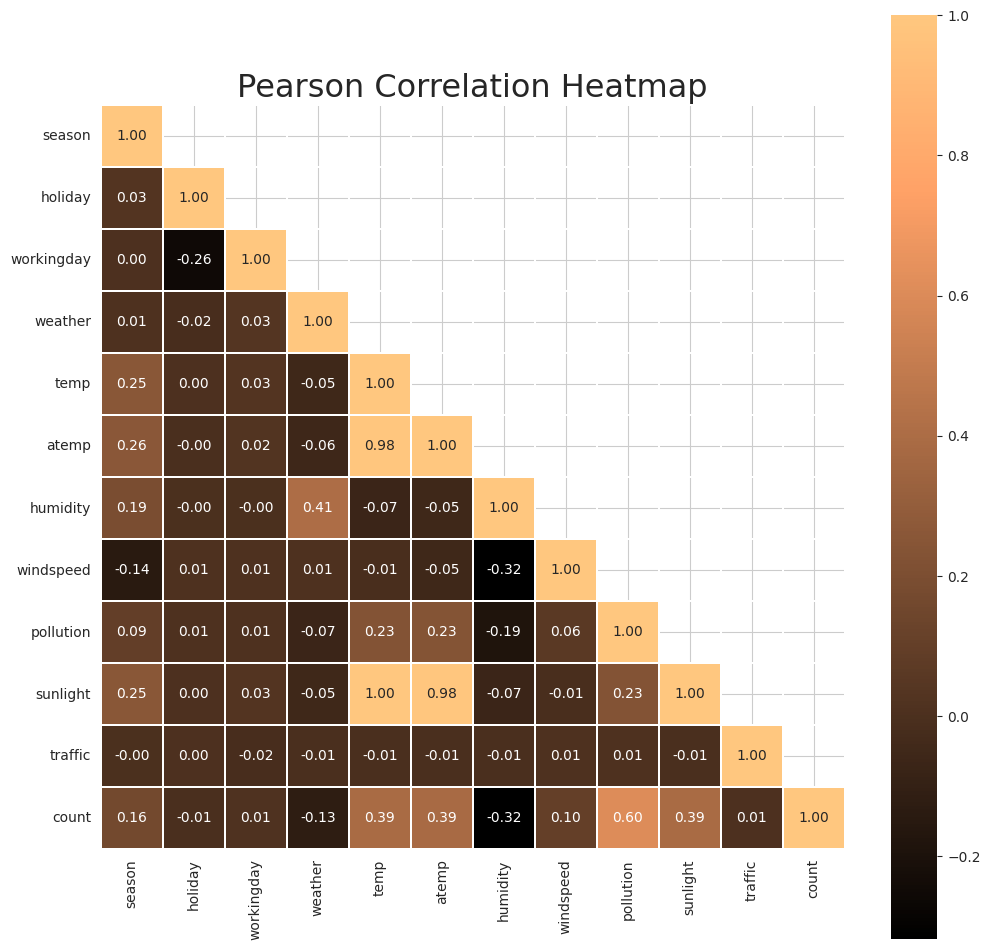

In [ ]:
correlation_matrix(df)

1. `temp` and `atemp` are highly related.
2. `temp` and `sunlight` are highly related, as expected.
3. The features `temp`, `atemp` and `sunlight` are related to the label `count` to the exact same degree (0.39).
4. The `pollution` feature is highly correlated with the label count (0.6). One possible explanation is that when the pollution level is very high and people are aware of this issue, they may choose to rent bikes instead of driving cars to reduce pollution, or maybe it's just noise.
5. `humidity` is inversely related to count, as expected since people are less inclined to ride bikes in humid weather.

By looking at the correlations, we notice that there are 3 very strong correlations between 3 features: `temp` (temperature), `atemp` (average temperature) and `sunlight`. Let's look at them individually:

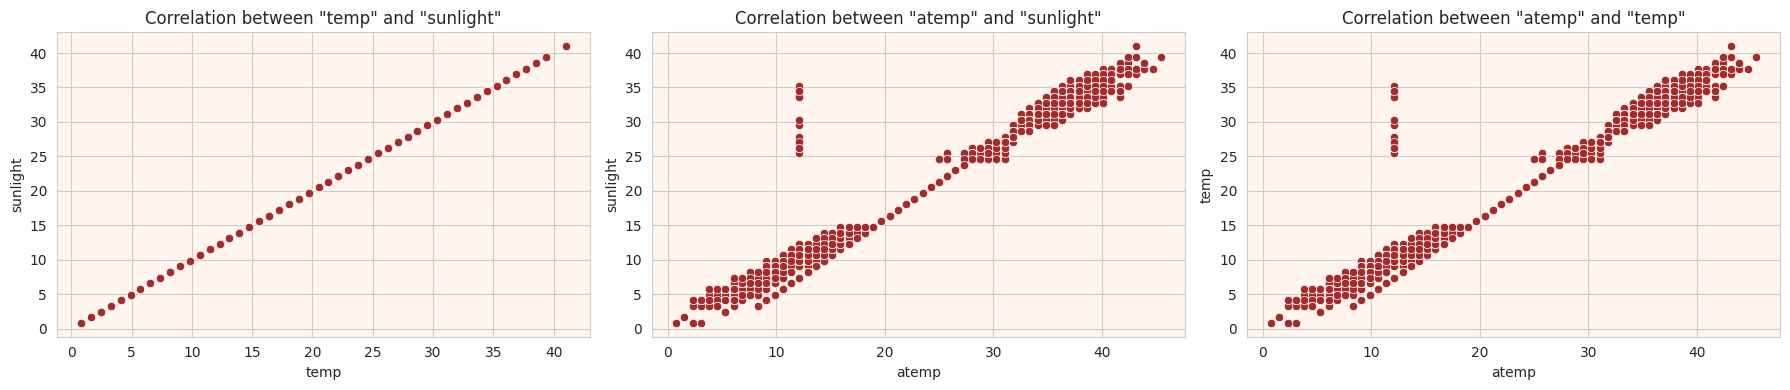

In [ ]:
# Define a list containing tuples of variable pairs
variable_pairs = [('temp', 'sunlight'), ('atemp', 'sunlight'), ('atemp', 'temp')]

# Create a figure and an array of subplots
fig, axes = plt.subplots(1, len(variable_pairs), figsize=(18, 4))

# Iterate through variable pairs and create scatter plots
for i, (x_var, y_var) in enumerate(variable_pairs):
    sns.scatterplot(x=x_var, y=y_var, data=df, ax=axes[i], color='brown')
    axes[i].set_xlabel(x_var)
    axes[i].set_ylabel(y_var)
    axes[i].set_title(f'Correlation between "{x_var}" and "{y_var}"')
    axes[i].set_facecolor('seashell')

# Adjust the layout of the subplots and display the figures
plt.tight_layout()
plt.show()

These graphs illustrate the numbers we see in the correlation matrix.<br>
The correlation between `temp` and `sunlight` is 1, meaning  they have a perfect positive linear relationship between them and we can see it by the straight line.<br>
The correlation between `atemp` and `sunlight` is 0.98, and this is also the correlation between `atemp` and `temp`. These two correlations have identical plots.<br><br>
When three features have the same correlations with each other, it suggests that there is a consistent relationship among all three pairs of features.
High correlation between pairs of features can indicate multicollinearity. **Multicollinearity** occurs when two or more independent variables in a regression model are highly correlated, making it difficult to separately identify the individual effect of each variable on the dependent variable.<br>
In order to reduces redundancy (when one or more features can be predicted  by other features) in our data, we might consider keeping only one of them and removing the others.

##**Pre-Proccesing**

### Split the dataframe

We will split the data to X and Y (Y is the label):

In [ ]:
def spilt_to_X_Y(data):
  '''
  input: data (the data we want to use)
  output: X (the data without the label),
          Y(the label)
  '''
  # Remove the label 'count' from X data
  X = data.drop(['count'], axis=1)
  # The Y data is the label 'count'
  Y = data[['count']]
  return X, Y

In [ ]:
X, Y = spilt_to_X_Y(df)

### Split to train and validation data


Before we start with the models, we will split the train data to train and validation. This is an important step because the validation set allows us to evaluate the performance of our models on the test data.<br>
Although the common choice is to split to 80% train and 20% validation, we decided to split it to 90% train and 10% validation. The reason is that the number of samples is not high, so we do not want to keep the train data too small.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

### Dealing with cyclical features

Feature "datetime" has information about date and time. It contains seconds, minutes, hours, days, and months which are circular information that repeats itself (for example, there are 60 seconds in a minute).<br>
Cyclical features are periodic features that repeat in a cycle, and while these features have a natural order, machine learning models may struggle to understand their cyclical nature.<br>
In order to represent these patterns effectively and help the model better capture the underlying periodicity, we will encode the cyclical features.

In [ ]:
def converting_to_datetime(data):
  '''
  input: data (the data we want to use)
  outpit: the 'datetime' column in a datetime format
  '''

  #  Convert the 'datetime' column to datetime format
  return pd.to_datetime(data['datetime'])

In [ ]:
def create_hour_feature(data):
  '''
  input: data (the data we want to use)
  output: a series containing the hour component extracted from the datetime values.
  '''

  # Extract the hour component from a datetime column.
  return data.datetime.dt.hour

We can now illustrate the problem of time as a cyclical feature. We will do so by using the hour of the day as an example. Let's extract the hours from the datetime:

In [ ]:
X_train_copy = X_train.copy()

X_train['datetime'] = converting_to_datetime(X_train)
X_train_copy['datetime'] = converting_to_datetime(X_train_copy)

# Sort the train data by 'datetime' for the next demonstration
X_train_copy = X_train_copy.sort_values(by='datetime')

Let's see an example of 3 hours: 21:00, 22:00 and 01:00:

In [ ]:
X_train['hour'] = create_hour_feature(X_train)
X_train_copy['hour'] = create_hour_feature(X_train_copy)

# Take lines 11, 12 and 13 for the next demonstration
X_train_copy.iloc[11:14]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,hour
6527,2011-01-01 21:00:00,1,0,0,2,16.40,20.455,87,12.9980,1.965986,16.401,0.004489,21
5949,2011-01-01 22:00:00,1,0,0,2,16.40,20.455,94,15.0013,6.888960,16.401,0.015615,22
4717,2011-01-02 01:00:00,1,0,0,2,18.04,21.970,94,16.9979,8.693812,18.041,0.004489,1


The time difference between records 6527 and 5949 is, of course, 1 hour. When the hour feature is left unencoded, the calculation works in this case: $23-22=1$.

However, examining rows 5949 and 4717 reveals a flaw in our encoding: $1-22=-21$, even though the records are only 3 hours apart.

To address this issue, we need to adjust the encoding of the feature so that 01:00 and 22:00 are recognized as being 3 hours apart.

A common approach for encoding cyclical data involves transforming the data into two dimensions using sine and cosine transformations.
To achieve this, we normalize the sine and cosine values to ensure they fall within a consistent range. We can do that using the following transformations:

$x_{\text{sin}} = sin(\frac{2\pi𝓧}{\max(x)})$

$x_{\text{cos}} = cos(\frac{2\pi𝓧}{\max(x)})$


**Encoding Date (day & month) and Time (hours)**

We need to encode the cyclical features using our sine and cosine transformation. When we examine the 'describe' table in the EDA section above, we notice that we only have information on hours, with no data for minutes or seconds. To address this, we will create a small helper function:

In [ ]:
def encode_cyclical_features(data, col, max_val):
  '''
  input: data (the data we want to use),
         col (the feature we want to transform),
         max_val (the maximum value of the cyclical feature)
  output: data (data with additional columns for the sin and cos
                transformations of the feature)
  '''

  # Sin transformation
  data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
  # Cos transformation
  data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
  return data

In [ ]:
def deal_with_cyclic_features(data):
  '''
  input: data (the data we want to use)
  output: the data with cyclical features encoded as sin and cos
          for the features 'hour', 'month' and 'day'
  '''

  # Encode 'hour'
  data = encode_cyclical_features(data, 'hour', 24)

  # Encode 'month'
  data['month'] = data.datetime.dt.month
  data = encode_cyclical_features(data, 'month', 12)

  # Encode 'day'
  data['day'] = data.datetime.dt.day
  data = encode_cyclical_features(data, 'day', 31)

  return data

In [ ]:
X_train = deal_with_cyclic_features(X_train)

**Dealing with the 'year' feature**

The last thing left in the `datetime` feature that we didn't deal with is the year. A year is not circular information, so we will not use the same technique we have used so far.
Simply, we will create a new feature named `year` that will contain the year of each sample.

In [ ]:
def create_year_feature(data):
  '''
  input: data (the data we want to use)
  output: data.datetime.dt.year (a series containing the year component
                                extracted from the datetime values)
  '''

  return data.datetime.dt.year

In [ ]:
X_train['year'] = create_year_feature(X_train)

Now we'll remove the uncoded features `datetime`, `hour`, `month` and `day`

In [ ]:
def remove_uncoded_cyclic_features(data):
  '''
  input: data (the data we want to use)
  output: the data without the features 'datetime', 'hour', 'month' and 'day'
  '''

  return data.drop(columns=['datetime','hour', 'month', 'day'])

In [ ]:
X_train = remove_uncoded_cyclic_features(X_train)

### Dealing with correlated features

As we explained in the EDA part regarding the multicollinearity problem among the three features: `temp`, `atemp`, and `sunlight`. The correlation between `temp` and `sunlight` formed a perfect linear relationship ($ρ=1$), and the correlation between the others was $ρ = 0.98$. Hence, we decided to address this issue by removing two of them, `atemp` and `sunlight`, leaving only the `temp` information.

In [ ]:
def remove_correlated_features(data):
  '''
  input: data (the data we want to use)
  output: the data without features 'atemp' and 'sunlight'

  '''
  return data.drop(columns=['atemp','sunlight'])

In [ ]:
X_train = remove_correlated_features(X_train)

### Dealing with outliers

We noticed outliers in the histograms plot in the EDA part, as the `pollution` and `windspeed` features had a long "tail" in their histograms. Let's take a closer look inside each of them:

In [ ]:
def plot_outliers(df, features, state):
    '''
    input: df (the data we want to use),
           features (the features we want to plot),
           state (before or after dealing with outliers)
    output: plot
    '''

    num_features = len(features)
    fig, axes = plt.subplots(1, num_features, figsize=(10*num_features, 5))  # Adjusted figsize

    for i, feature in enumerate(features):
        sns.histplot(df[feature], bins=30, kde=True, color='sienna', ax=axes[i])
        axes[i].set_title(f"Distribution of '{feature}' Feature")
        axes[i].set_xlabel(f"{feature} level")
        axes[i].set_ylabel("count")

    plt.suptitle(f"{state} dealing with outliers", fontsize=14, fontweight='bold')
    plt.tight_layout()  # Adjust spacing between plots
    plt.show()

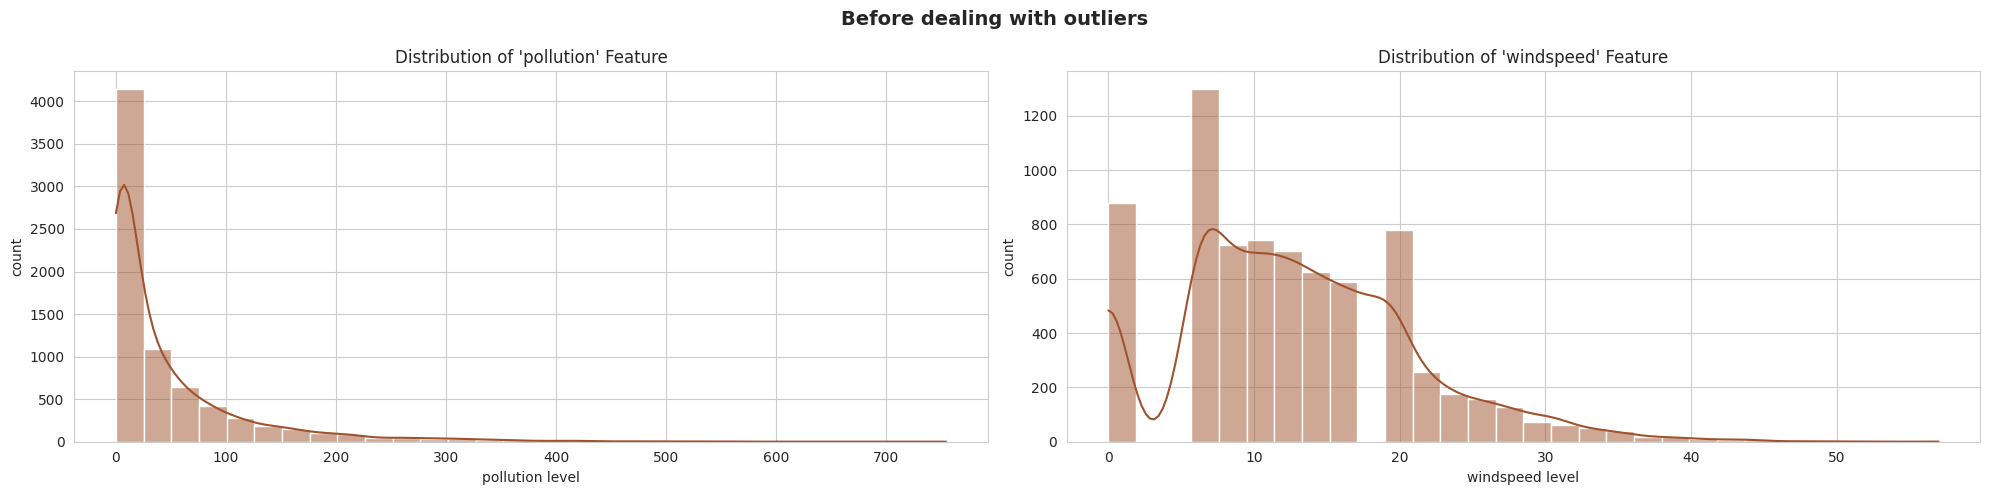

In [ ]:
plot_outliers(X_train, ['pollution', 'windspeed'], 'Before')

We definitely observe outliers in these features, but we don't want to lose any information since our entire training set (including both the train and validation sets) contains only 8k samples, which is not a large number.

To address this issue without sacrificing valuable information, we can apply a technique called **Winsorization** using the SciPy library. This method helps reduce the impact of outliers by replacing the smallest and largest values in a dataset with observations closest to them, rather than removing them entirely.

We choose limits of 0 for the smaller data values (on the left side) because, based on the plot, it is noticeable that the outliers are larger values located on the right side of the histogram. Therefore, we focus on this side, replacing values above the $95th$ percentile with the value at the $95th$ percentile.

In [ ]:
def winsorize_continuous_features(df, features):
    '''
    input: df (the data we want to use), features (the features we want to deal with their outliers)
    output: the data after dealing with outliers
    '''
    # Create a copy of the data
    df_winsorized = df.copy()

    for feature in features:
        # Apply winsorazation to a specific feature
        df_winsorized[feature] = winsorize(df_winsorized[feature], limits=(0, 0.05))

    return df_winsorized

In [ ]:
X_train = winsorize_continuous_features(X_train, ['pollution', 'windspeed'])

Now that we dealt with the outliers, let's look at the new plots of these features:

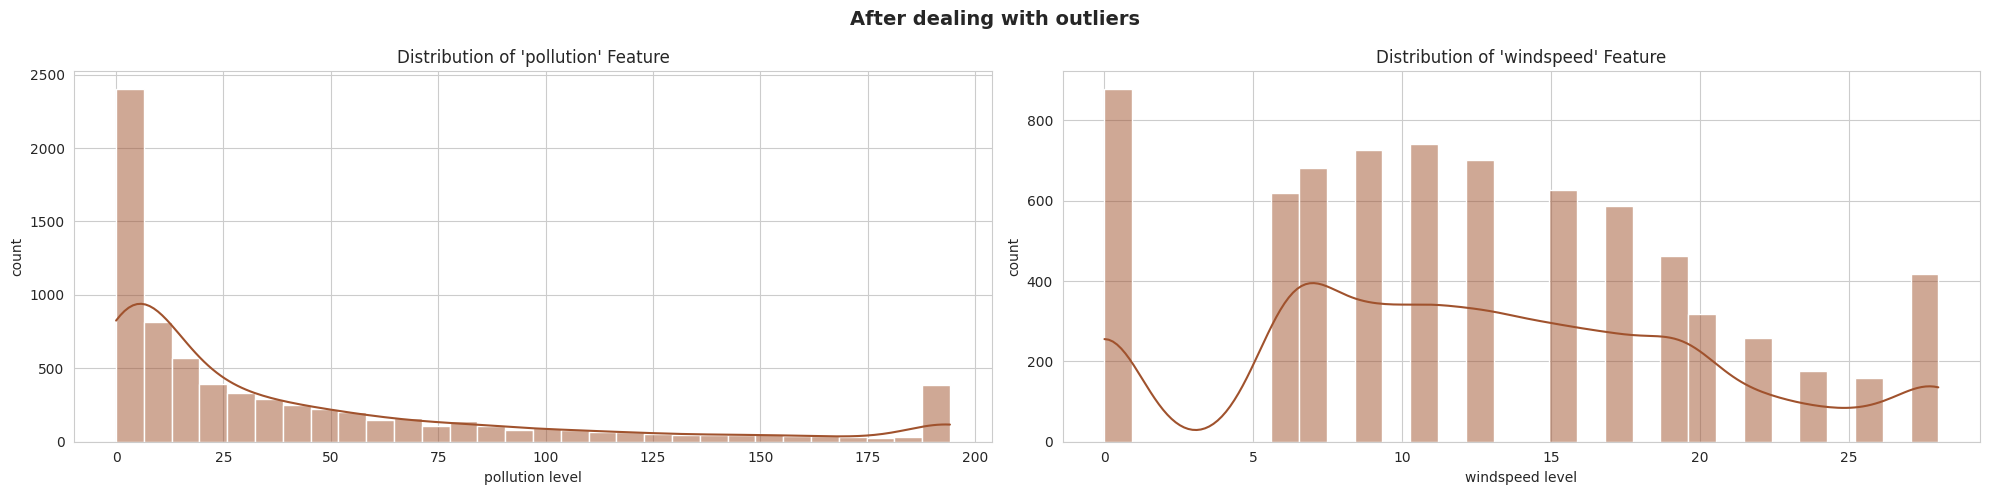

In [ ]:
plot_outliers(X_train, ['pollution', 'windspeed'], 'After')

### Data transformation

We attempted normalization on our data using three different techniques:
*MinMaxScaler*, *StandardScaler*, and *PowerTransformation*.<br>
Among these, **MinMaxScaler** provided the best scores, but overall, our models performed slightly better without any normalization.<br>
Thus, this step is not included in the final pipeline.

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# Create a subset DataFrame with only the features to normalize
# df_subset = df[continuous_features]

# Instantiate the MinMaxScaler
# scaler = MinMaxScaler()

# Fit and transform the subset data
# df_scaled_subset = scaler.fit_transform(df_subset)

# Convert back to DataFrame for display (optional)
# df_scaled_subset = pd.DataFrame(df_scaled_subset, columns=continuous_features)

# Replace the original values in the original DataFrame with the scaled values
# df[continuous_features] = df_scaled_subset

### Dimensionality reduction

We attempted to reduce dimensionality with PCA initially. As expected, it didn't improve our tree-based algorithms. PCA identifies components that explain 99% of the data variance (as implemented in the function below) and projects the data onto these components using a dot product.

Tree-based algorithms rely on the interpretability of feature, splitting, and gain calculation from each split. Therefore, PCA is not a suitable technique for the algorithms we selected for this project. Subsequently, we explored other techniques for feature selection, taking into account the feature importance derived from our tree-based models.

In [ ]:
from sklearn.decomposition import PCA

def get_principal_components(X: np.array, p: float) -> np.array:
    pca = PCA(p)
    pca.fit(X)
    return pca.components_

In [ ]:
# train_components = get_principal_components(df.drop('count', axis=1),0.99)
# train_data_pca = np.dot(df.drop('count', axis=1), train_components.T)
# print(f'number of components which preserve at least 99% of the variance: {len(train_components)}')

### One-Hot Encoding

As we saw earlier, our dataset contains numerical categorical features,
`season` and `weather`, each with 4 distinct values (categories).<br>
To address these features, which lack inherent order or ranking, we used **One-Hot Encoding**.<br>This technique represents each numerical categorical variable as a binary vector, allowing us to transform these variables into a more suitable format for our analysis.

In [ ]:
def one_hot_encoding(data, feature):
  '''
  input: data (the data we want to use),
         feature (the feature we want to encode)
  output: the data after encoding the feature
  '''
  #  Create a dummy variables for the categorical feature
  encoded_feature = pd.get_dummies(data[feature],prefix=feature)
  # Add the dummy variables to the data
  data = pd.concat([data,encoded_feature],axis=1)
  # Remove the original categorical feature from the data
  data = data.drop(columns=[feature])

  if feature == 'weather' and 'weather_4' not in data.columns:
    # if the feature is 'weather' and there is no 'weather_4' feature, add a new column 'weather_4' filled with zeros
    data['weather_4'] = 0

  return data

In [ ]:
X_train = one_hot_encoding(X_train, 'season')
X_train = one_hot_encoding(X_train, 'weather')

### Pre-Proccesing Pipeline

Now, let's apply the same process to our validation set as we did to the training set:

In [ ]:
def pre_proccesing_pipeline(data):
  '''
  input: data (the data we want to use)
  output: data (the data after pre-proccesing)
  '''

  # Dealing with cyclic features
  data['datetime'] = converting_to_datetime(data)
  data['hour'] = create_hour_feature(data)
  data = deal_with_cyclic_features(data)
  data['year'] = create_year_feature(data)
  data = remove_uncoded_cyclic_features(data)

  # Dealing with highly correlated features
  data = remove_correlated_features(data)

  # Dealing with outliers
  data = winsorize_continuous_features(data, ['pollution', 'windspeed'])

  # One-hot encoding
  data = one_hot_encoding(data, 'season')
  data = one_hot_encoding(data, 'weather')

  return data

In [ ]:
X_val = pre_proccesing_pipeline(X_val)
X_val

,holiday,workingday,temp,humidity,windspeed,pollution,traffic,hour_sin,hour_cos,month_sin,...,day_cos,year,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
7165,0,0,25.42,61,7.0015,7.510678,0.015615,1.000000,6.123234e-17,1.224647e-16,...,0.528964,2011,0,1,0,0,0,1,0,0
3862,0,1,24.60,78,12.9980,3.550944,0.004489,-0.258819,9.659258e-01,1.224647e-16,...,-0.874347,2012,0,1,0,0,0,0,1,0
3307,0,1,14.76,57,15.0013,37.737255,0.004489,-0.866025,5.000000e-01,-2.449294e-16,...,-0.758758,2012,0,0,0,1,1,0,0,0
2492,0,0,32.80,49,27.9993,54.877070,0.015615,-1.000000,-1.836970e-16,-5.000000e-01,...,0.820763,2011,0,0,1,0,0,0,1,0
6783,0,1,20.50,77,6.0032,7.907176,0.000242,-0.500000,8.660254e-01,-8.660254e-01,...,-0.758758,2012,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169,0,1,24.60,78,11.0014,9.411050,0.000242,1.000000,6.123234e-17,-8.660254e-01,...,-0.994869,2012,0,0,1,0,1,0,0,0
6589,0,1,19.68,72,12.9980,0.688616,0.000000,0.707107,7.071068e-01,1.000000e+00,...,-0.954139,2012,1,0,0,0,1,0,0,0
5537,0,1,11.48,48,0.0000,7.793927,0.004489,-0.707107,7.071068e-01,-2.449294e-16,...,-0.874347,2012,0,0,0,1,1,0,0,0
1168,0,1,22.96,94,0.0000,2.858707,0.004489,0.866025,5.000000e-01,5.000000e-01,...,-0.994869,2012,0,1,0,0,0,0,1,0


After executing the pipeline, we'll want to make sure that the number of columns in the validation data is equal to the number of columns in the the train data:

In [ ]:
X_val.shape

(817, 22)

In [ ]:
X_train.shape

(7347, 22)

## **Model selection**

### Models

We'll create a dictionary to save the models:

In [ ]:
models = {'XGBoost': None,
          'Adaboost': None,
          'RandomForest': None}

Now, we will create functions for each model and utilize **GridSearchCV** from scikit-learn to identify the optimal hyperparameters for our models. The search was conducted using **3-fold cross-validation**, and we evaluated the models' performance based on RMSE scores calculated on the training data.

**XGBoost**

**XGBoost** is a gradient boosting algorithm that uses decision trees as its "weak" predictors. Beyond that, its implementation was specifically engineered for optimal performance and speed and is renowned for its efficiency and effectiveness in handling structured/tabular data.


*   Boosting is an ensemble method, combining predictions from several models into one.
*   Gradient boosting is a specific type of boosting, named as such because it minimizes the loss function using a gradient descent algorithm.

Let's explain the importance of each hyperparameters we chose to optimize:
* `objective`: This parameter defines the learning task, which in our case is linear regression or gamma regression because it's a regression task.

* `learning rate`: This parameter controls the step size at each iteration while moving toward a minimum of the loss function. It is a critical hyperparameter that influences the convergence and performance of the model.

* `n_estimators`: This parameter represents the number of boosting rounds or trees to be built in the ensemble. The model will iterate over the dataset this many times.

* `seed`: The seed is used to initialize the random number generator. Setting a specific seed ensures the reproducibility of the results. We set it to 42, following the common practice of using 'random_state' in other algorithms.

In [ ]:
def run_XGBoost(x_train, y_train):
  '''
  input: X_train (the train data without label),
         Y_train (the label of the train data)
  output: the fitted GridSearchCV object
  '''
  # Create an instance of the XGBoost Regressor model
  xgb_r = xg.XGBRegressor()

  # Define a dictionary containing the hyperparameters to be tuned using grid search
  XGBoost_parameters = {'objective' : ['reg:linear', 'reg:gamma'],
                        'learning_rate' : [0.01, 0.1, 0.2, 0.3],
                        'n_estimators' : [50, 100, 200],
                        'seed': [42]}
  # Create an instance of GridSearchCV which will search for the best combination of hyperparameters for the XGBoost Regressor model
  grid_search_XGBoost = GridSearchCV(xgb_r,
                                     XGBoost_parameters,
                                     scoring='neg_root_mean_squared_error',
                                     cv=3)

  # Fit the GridSearchCV object to the training data
  grid_search_XGBoost.fit(x_train, y_train)

  return grid_search_XGBoost

**AdaBoost**

**AdaBoost** is an ensemble learning algorithm that combines predictions from multiple weak learners to create a robust model. AdaBoost uses shallow decision trees as base learners. AdaBoost, as well, uses the boosting technique to combine predictions from several trees into one, and specifically employs gradient boosting too.


***The hyperparametrs optimized are the same as the XGBoost***

In [ ]:
def run_AdaBoost(x_train, y_train):
  '''
  input: X_train (the train data without label),
         Y_train (the label of the train data)
  output: the fitted GridSearchCV object
  '''
  # Create an instance of the AdaBoost Regressor model
  ab = AdaBoostRegressor()

  # Define a dictionary containing the hyperparameters to be tuned using grid search
  AdaBoost_parameters = {'n_estimators' : [50, 100, 200],
                         'learning_rate' : [0.01, 0.1, 0.2, 0.3],
                         'random_state' : [42]}

  # Create an instance of GridSearchCV which will search for the best combination of hyperparameters for the AdaBoost Regressor model
  grid_search_AdaBoost = GridSearchCV(ab,
                                      AdaBoost_parameters,
                                      scoring='neg_root_mean_squared_error',
                                      cv=3)

  # Fit the GridSearchCV object to the training data
  grid_search_AdaBoost.fit(x_train, y_train)

  return grid_search_AdaBoost

**Random Forest**

**Random Forest** is an ensemble learning algorithm that creates a forest of decision trees during training. It builds each tree independently without iteratively correcting errors. It leverages the principle of bagging, where each tree is trained on a random subset of the data, and their predictions are combined to produce a more robust and accurate overall model.

The hyperparameters we wanted to optimize are:<br>
* `n_estimators`: Sets the number of trees in the forest, influencing the model's complexity. A larger number of trees can increase the accuracy of the model, but it can also increase the risk of overfitting and make the model slower to train and predict.
* `max_depth`: Sets the maximum depth of each decision tree in the forest.

In [ ]:
def run_RandomForest(x_train, y_train):
  '''
  input: X_train (the train data without label),
         Y_train (the label of the train data)
  output: the fitted GridSearchCV object
  '''
  # Create an instance of the Random Forest Regressor model
  rf = RandomForestRegressor()

  # Define a dictionary containing the hyperparameters to be tuned using grid search
  rf_parameters = {'n_estimators': [20, 50, 100, 200],
                   'max_depth':[10, 25, 40, 55]}

  # Create an instance of GridSearchCV which will search for the best combination of hyperparameters for the Random Forest Regressor model
  grid_search_rf = GridSearchCV(rf,
                                rf_parameters,
                                scoring='neg_root_mean_squared_error',
                                cv=3)

  # Fit the GridSearchCV object to the training data
  grid_search_rf.fit(x_train, y_train)

  return grid_search_rf

**Linear Regression**

We attempted to use **Linear Regression** and **SVR** (Support Vector Machine for regression, which is based on linear relations as well), given that all our existing models are tree-based algorithms and may not effectively capture linear relationships.<br>
However, even after normalization or dimensionality reduction attempts, the scores obtained from these linear models were significantly lower than our tree-based algorithms.<br>
As we were asked for only 3 models, we decided to remove the SVR and save this cell of Linear Regression to document our attempt and clarify that we experimented with various algorithms, ultimatly finding the tree-based models to be the most effective on our data.

In [ ]:
'''
from sklearn.linear_model import LinearRegression

def run_LinearRegression(x_train, y_train):

  lr = LinearRegression()

  lr_parameters = {'fit_intercept': [True, False]}

  grid_search_lr = GridSearchCV(lr,
                                 lr_parameters,
                                 scoring='neg_root_mean_squared_error',
                                 cv=3)

  grid_search_lr.fit(x_train, y_train)

  return grid_search_lr
'''

"\nfrom sklearn.linear_model import LinearRegression\n\ndef run_LinearRegression(x_train, y_train):\n\n  lr = LinearRegression()\n\n  lr_parameters = {'fit_intercept': [True, False]}\n\n  grid_search_lr = GridSearchCV(lr,\n                                 lr_parameters,\n                                 scoring='neg_root_mean_squared_error',\n                                 cv=3)\n\n  grid_search_lr.fit(x_train, y_train)\n\n  return grid_search_lr\n"

### Run all models

In [ ]:
def run_all_models(x, y):
  '''
  input: x (the data without the label),
         y (the label of the data)
  output: models_dict (dictionary with the models as the keys and
          the fitted GridSearch object for each model as the value)
  '''
  models_dict = {}
  # Fit XGBoost on the train data and save the fitted GridSearch object
  models_dict['XGBoost'] = run_XGBoost(x, y)
  # Fit AdaBoost on the train data and save the fitted GridSearch object
  models_dict['AdaBoost'] = run_AdaBoost(x, y)
  # Fit Random Forest on the train data and save the fitted GridSearch object
  models_dict['RandomForest'] = run_RandomForest(x, y)

  return models_dict

In [ ]:
models = run_all_models(X_train, Y_train)

After running  all the models, we created a function that gives back a dictionary with each model's name and its training RMSE scores:

In [ ]:
def cv_scores(models):
  '''
  input: models (a dictionary with the models and their fitted GridSearch objects)
  output: cv_scores_dict (a dictionary with the cv score for each model)
  '''
  cv_scores_dict = {}
  # Assign the best cross-validation score of the XGBoost model to the corresponding key
  cv_scores_dict['XGBoost'] = models['XGBoost'].best_score_
  # Assign the best cross-validation score of the AdaBoost model to the corresponding key
  cv_scores_dict['AdaBoost'] = models['AdaBoost'].best_score_
  # Assign the best cross-validation score of the Random Forest model to the corresponding key
  cv_scores_dict['RandomForest'] = models['RandomForest'].best_score_

  return cv_scores_dict

In [ ]:
cv_scores_dict = cv_scores(models)
# View the cv score for each model
cv_scores_dict

{'XGBoost': -45.74859529143523,
 'AdaBoost': -102.47358556685134,
 'RandomForest': -57.941688322920136}

## **Evaluation on validation set**

### Validation score

In order to asset the performance of our models on an unseen data, we would like to check the validation's score, using the RMSE score.<br>
At the end of this section, we printed the validation scores of our chosen models, while our goal is to keep the model with the lowest error.

In [ ]:
def evaluate_single_model(x, y, model):
  '''
  input: x (validation data without the label),
         y (the label of the validation data),
        model (the best hyperparameters of the model)
  output: RMSE between the true target variable 'y' and the predicted 'y_pred'
  '''
  # Predict the target variable
  y_pred = model.predict(x)
  return (np.sqrt(mean_squared_error(y, y_pred)))

In [ ]:
def evaluate_all_models(x, y, models_dict):
  '''
  input: x (validation data without the label),
         y (the label of the validation data),
         models_dict (dictionary with the best hyperparameters of each model)
  output: test_set_scores (dictionary with the evaluation scores of each model
                            on the validation set)
  '''
  test_set_scores = {}
  # Evaluate the performance of each trained model on the validation set
  for k, v in models_dict.items():
    test_set_scores[k] = evaluate_single_model(x, y, v)
  return test_set_scores

In [ ]:
def trained_models(models):
  '''
  input: models (dictionary with fitted GridSearch object of each model)
  output: trained_models_dict (dictionary with the best hyperparameters of each model)
  '''
  trained_models_dict = {}
  # Assign the best estimator (model with the best hyperparameters) found during the grid search for the each model
  trained_models_dict['XGBoost'] = models['XGBoost'].best_estimator_
  trained_models_dict['AdaBoost'] = models['AdaBoost'].best_estimator_
  trained_models_dict['RandomForest'] = models['RandomForest'].best_estimator_
  return trained_models_dict

In [ ]:
trained_models_dict = trained_models(models)

In [ ]:
test_set_scores = evaluate_all_models(X_val, Y_val, trained_models_dict)
# View the validation RMSE for each model
test_set_scores

{'XGBoost': 46.744588157968565,
 'AdaBoost': 106.81219512854643,
 'RandomForest': 57.16233234675336}

### Feature importance

Understanding feature importance helps us identify which features contribute most to the model's predictions. By analyzing feature importance, we can optimize the model, improve interpretability, and focus on the most influential aspects of the data. We will achive these goals by using graphical representation for each model.

#### Functions for feature importance

In [ ]:
def plot_feature_importance(feature_importance, X, model):
    """
    input: feature_importance (features importance in the model),
           X (the data we want to use),
           model (dictionary with fitted GridSearch object of each model)
    output: sorted_feature_names (array of sorted feature importance),
            plots the feature importance of the model
    """
    # Compute the indices that would sort the array 'feature_importance' in ascending order
    sorted = np.argsort(feature_importance)
    # Reorder the 'feature_importance' array based on the sorted indices
    sorted_feature_importances = feature_importance[sorted]
    # Rearrange the feature names in the same order as their corresponding importances
    sorted_feature_names = np.array(X.columns)[sorted]

    # plot
    pos = np.arange(sorted.shape[0]) + .5
    plt.rcParams["figure.figsize"] = (12,8)
    # Create a horizontal bar plot
    bars = plt.barh(pos, sorted_feature_importances, align='center', color='lightsalmon')

    # Adding precentage labels
    for bar, importance in zip(bars, sorted_feature_importances):
        plt.text(bar.get_width() + 0.000005, bar.get_y() + bar.get_height() / 2, f'{importance*100:.2f}%', ha='left', va='center')

    # Set the y-axis tick positions and labels
    plt.yticks(pos, sorted_feature_names)
    # Set the title of the plot
    plt.title(f'Feature Importance in {model} Predictor')
    # Display the plot
    plt.show()

    return sorted_feature_names

In [ ]:
def model_feature_importance(data, model, all_models_dict):
  '''
  input: data (the data we want to use),
         model (the name of the model),
         all_models_dict (dictionary with fitted GridSearch object of each model)
  output: best_features (array of sorted feature importance)
  '''
  # Retrieve the best estimator for a specific model
  best_model = all_models_dict[model].best_estimator_
  # Extract the feature importances
  feature_importance = best_model.feature_importances_
  best_features = plot_feature_importance(feature_importance, data, model)
  return best_features

In [ ]:
X_data_best_features = {}

#### XGBoost feature importance

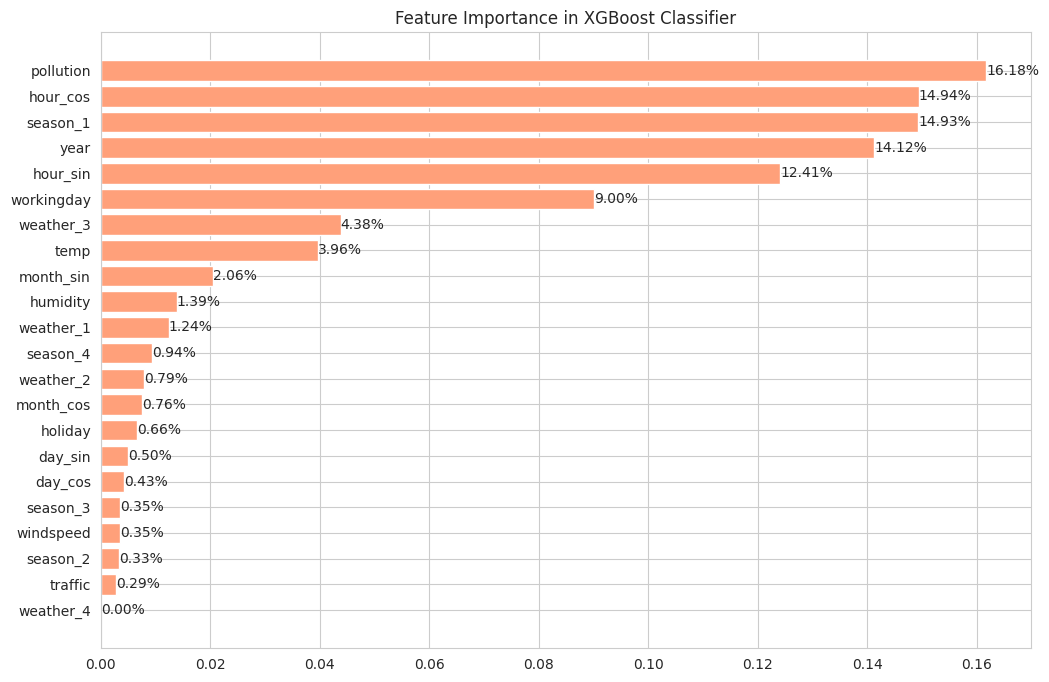

In [ ]:
best_feature_xgboost = model_feature_importance(X_train, 'XGBoost', models)
X_data_best_features['XGBoost'] = best_feature_xgboost

#### AdaBoost feature importance

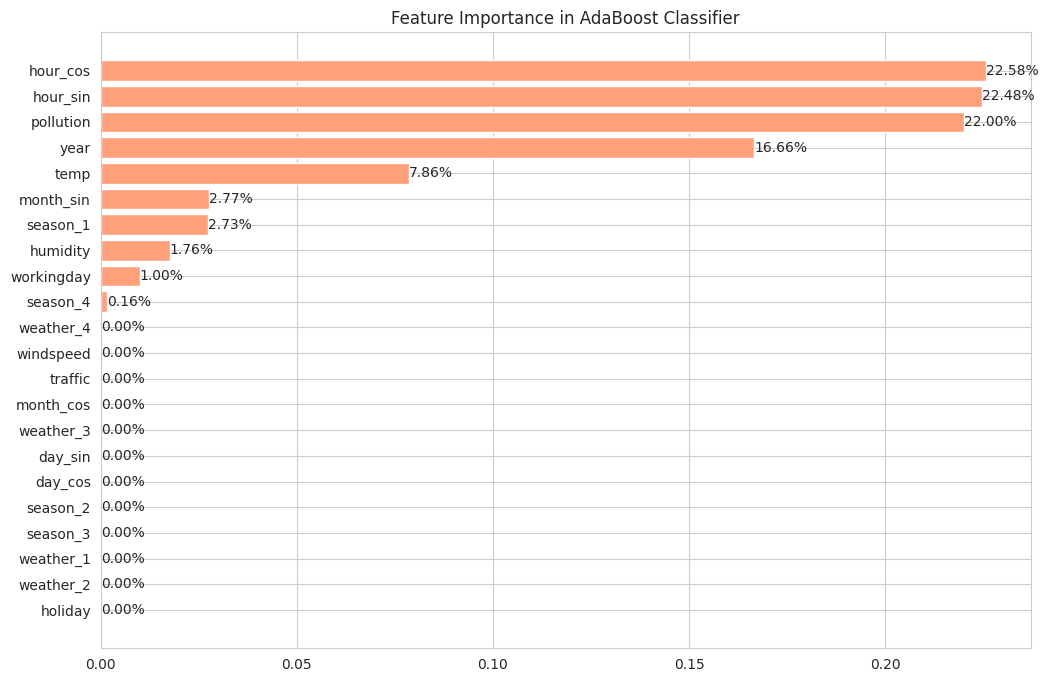

In [ ]:
feature_importance_AdaBoost = model_feature_importance(X_train, 'AdaBoost', models)
X_data_best_features['AdaBoost'] = feature_importance_AdaBoost

#### Random Forest feature importance

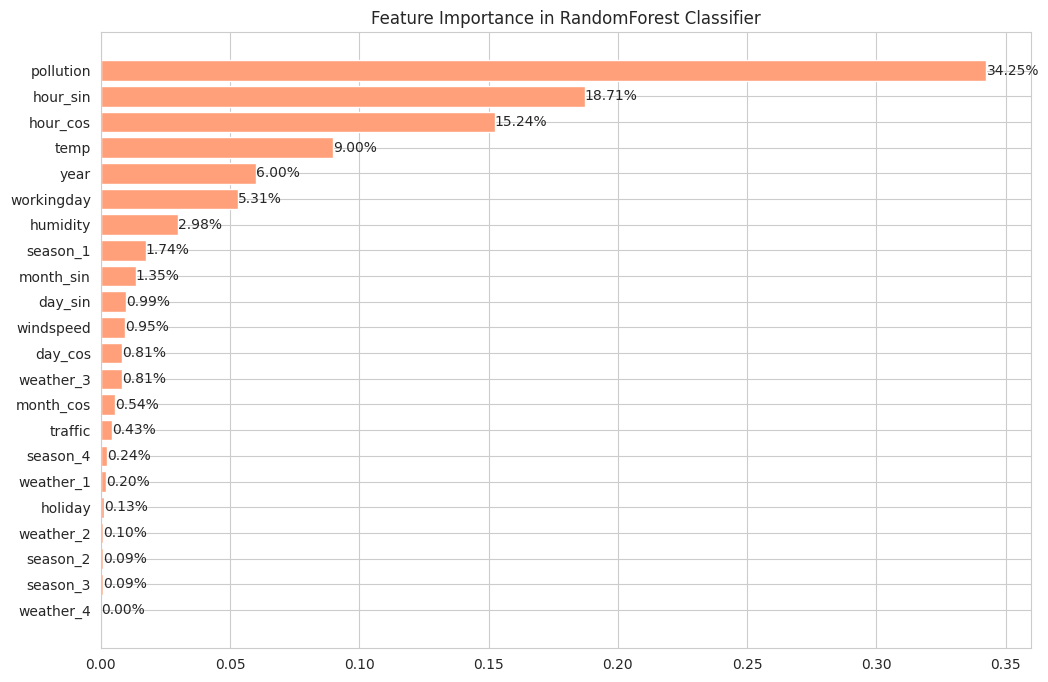

In [ ]:
best_feature_RandomForest = model_feature_importance(X_train, 'RandomForest', models)
X_data_best_features['RandomForest'] = best_feature_RandomForest

#### Feature selection

In this section, we'll perform feature selection to identify the most informative features for our models. This process involves retaining a subset that contributes significantly to predictive performance, and identifying the optimal number of features per model.

In [ ]:
def run_all_models_best_features(data, x_dict, y):
  '''
  input: data (the data we want to use without the label),
         x_dict (dictionary with the feature importance of each model),
         y (the label of the data)
  output: models_dict (dictionary with the models as the keys and the
                      fitted GridSearch object for each model as the value)
  '''
  models_dict = {}
  # Train an XGBoost model with the specified input features
  models_dict['XGBoost'] = run_XGBoost(data[x_dict['XGBoost']], y)
  # Train an Random Forest model with the specified input features
  models_dict['RandomForest'] = run_RandomForest(data[x_dict['RandomForest']], y)
  # Train an AdaBoost model with the specified input features
  models_dict['AdaBoost'] = run_AdaBoost(data[x_dict['AdaBoost']], y)

  return models_dict

In [ ]:
def evaluate_all_models_best_features(x, y, models_dict, x_dict):
  '''
  input: data (the validation data without the label),
         y (the label of the validation data)
  output: test_set_scores (dictionary with the evaluation scores of each model
                          on the validation set)
  '''
  test_set_scores = {}
  # Evaluate the performance of each trained model on the validation set
  for k, v in models_dict.items():
    test_set_scores[k] = evaluate_single_model(x[x_dict[k]], y, v)
  return test_set_scores

We aimed to visualize the impact of dropping features on both training and validation RMSE scores for each of our models, limiting the feature drop range to (3,10) to address computational costs and running time constraints in order to prevent overfitting.

In [ ]:
def select_how_many_fatures_to_drop(data, x_dict, Y_train, X_val, Y_val):
  '''
  input: data (the train data without the label),
         x_dict (dictionary with the feature importance of each model),
         Y_train (the label of the train data),
         X_val (the validation data without the label),
         Y_val (the label of the validation data)
  output: XGBoost_RMSE_train (list with train RMSE for each number of features dropped in XGBoost),
          XGBoost_RMSE_val (list with validation RMSE for each number of features dropped in XGBoost),
          RandomForest_RMSE_train (list with train RMSE for each number of features dropped in Random Forest),
          RandomForest_RMSE_val (list with validation RMSE for each number of features dropped in Random Forest),
          AdaBoost_RMSE_train (list with train RMSE for each number of features dropped in AdaBoost),
          AdaBoost_RMSE_val (list with validation RMSE for each number of features dropped in AdaBoost)
  '''
  # lists ot contain the RMSE for to train/validation of the a model according to number of features dropped
  XGBoost_RMSE_train = []
  XGBoost_RMSE_val = []
  RandomForest_RMSE_train = []
  RandomForest_RMSE_val = []
  AdaBoost_RMSE_train = []
  AdaBoost_RMSE_val = []

  for i in range(3,10):

    # Create a copy of the dictionary 'x_dict' and modify the input features for each model by slicing the lists to exclude the first i elements
    x_dict_copy = x_dict.copy()
    x_dict_copy['XGBoost'] = x_dict_copy['XGBoost'][i:]
    x_dict_copy['RandomForest'] = x_dict_copy['RandomForest'][i:]
    x_dict_copy['AdaBoost'] = x_dict_copy['AdaBoost'][i:]

    # Train all models
    models_dict = run_all_models_best_features(data, x_dict_copy, Y_train)

    # Calculate and store the cross-validation RMSE scores for each model
    cv_scores_dict = cv_scores(models_dict)
    XGBoost_RMSE_train.append(cv_scores_dict['XGBoost'])
    RandomForest_RMSE_train.append(cv_scores_dict['RandomForest'])
    AdaBoost_RMSE_train.append(cv_scores_dict['AdaBoost'])

    # Retrieve the best trained models for each model
    trained_models_dict_best_feature = trained_models(models_dict)

    # Evaluate the performance of the best trained models on the validation set
    val_set_scores_best_features = evaluate_all_models_best_features(X_val, Y_val, trained_models_dict_best_feature, x_dict_copy)
    XGBoost_RMSE_val.append(val_set_scores_best_features['XGBoost'])
    RandomForest_RMSE_val.append(val_set_scores_best_features['RandomForest'])
    AdaBoost_RMSE_val.append(val_set_scores_best_features['AdaBoost'])

  return XGBoost_RMSE_train, XGBoost_RMSE_val, RandomForest_RMSE_train, RandomForest_RMSE_val, AdaBoost_RMSE_train, AdaBoost_RMSE_val


In [ ]:
XGBoost_RMSE_train, XGBoost_RMSE_val, RandomForest_RMSE_train, RandomForest_RMSE_val, AdaBoost_RMSE_train, AdaBoost_RMSE_val = select_how_many_fatures_to_drop(X_train, X_data_best_features, Y_train, X_val, Y_val)

In [ ]:
def plot_feature_selection(model_train, model_val, model):
  '''
  input: model_train (RMSE train scores for each number of features dropped),
         model_val (RMSE validation scores for each number of features dropped),
         model (the name of the model)
  output: model_val.index(min(model_val)) + 3 (the number of features dropped that
                                               gives the lowest validation RMSE)
  '''
  num_of_samples = range(3,10)
  sns.set(style="whitegrid")
  # Create a new figure with a size of 10x6 inches
  plt.figure(figsize=(8, 4))
  # Plot the train and validation RMSE values against the number of dropped features
  sns.lineplot(x=num_of_samples, y=list(map(abs,model_train)), label=f'Train {model} RMSE', color='saddlebrown', linewidth=4)
  sns.lineplot(x=num_of_samples, y=model_val, label=f'Validation {model} RMSE', color='lightsalmon', linewidth=4)

  # Find the minimum validation RMSE value and its corresponding index
  min_val = min(model_val)
  min_val_index = model_val.index(min_val)
  # Add acatter plot point to highlight the minimum validation RMSE value
  plt.scatter(min_val_index + 3, min_val, zorder=5, linewidths=6, edgecolors='grey')

  # Find the minimum train RMSE value and its corresponding index
  min_train = min(list(map(abs,model_train)))
  min_train_index = list(map(abs,model_train)).index(min_train)
  # Add acatter plot point to highlight the minimum train RMSE value
  plt.scatter(min_train_index + 3, min_train, zorder=5, linewidths=6, edgecolors='grey')

  # Set the labels for the x-axis, y-axis and title. Add a legend
  plt.xlabel('number of features dropped')
  plt.ylabel('RMSE')
  plt.legend()
  plt.title(f'Train and Validation {model} RMSE vs Number of dropped features')
  # Set the limits for the x-axis
  plt.xlim(2, 10)
  plt.show()

  return model_val.index(min(model_val)) + 3

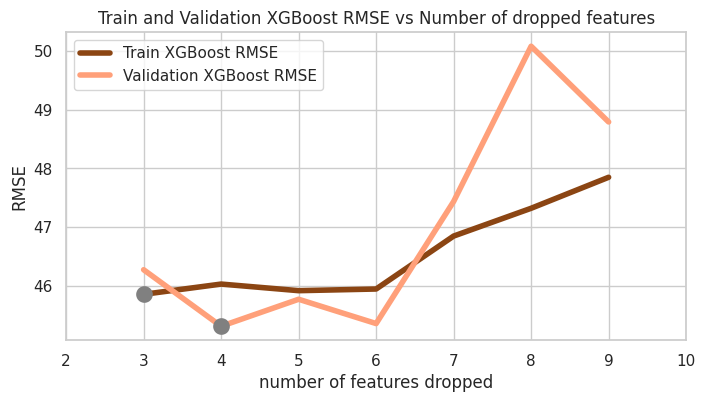

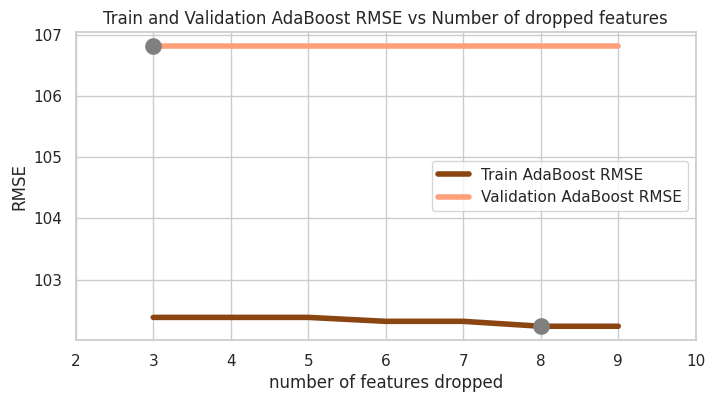

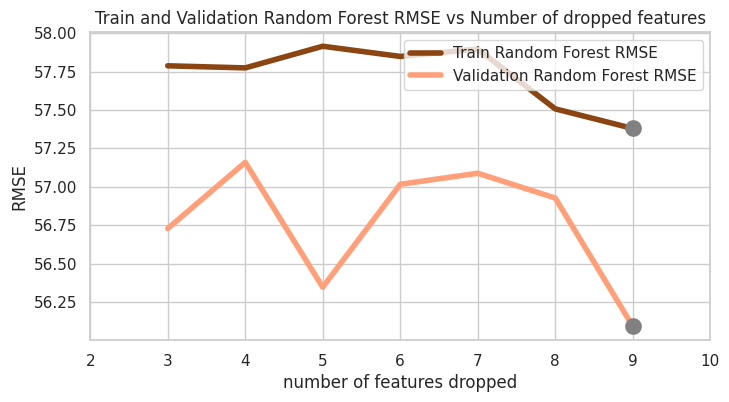

In [ ]:
num_features_to_drop_XGBoost = plot_feature_selection(XGBoost_RMSE_train, XGBoost_RMSE_val, 'XGBoost')
num_features_to_drop_AdaBoost = plot_feature_selection(AdaBoost_RMSE_train, AdaBoost_RMSE_val, 'AdaBoost')
num_features_to_drop_RandomForest = plot_feature_selection(RandomForest_RMSE_train, RandomForest_RMSE_val, 'Random Forest')

The gray dots represent the optimal number of features for each of the models.

We'll create a dictionary to hold the number of features dropped that gives the lowest RMSE on the validation in each model.<br>
We chose to exclude Adaboost's result, since the optimal dot in this model is equal in most of the situations. Therefore we went back to the "AdaBoost feature importance" section, and recognaized that the highest number of features we can throw away, without impairing the optimal result, is 12. This is because these 12 feature explain 0% of the model.

In [ ]:
features_to_remove = {}
features_to_remove['XGBoost'] = num_features_to_drop_XGBoost
features_to_remove['AdaBoost'] = 12
features_to_remove['RandomForest'] = num_features_to_drop_RandomForest

## **Evaluation on test data**

### Functions for the pipeline

These are functions that were already used during the assignment. Because we are choosing to use different number of features in each model, we will perform slicing so we created new functions:

In [ ]:
def run_all_models_best_features_pipeline(data, x_dict, y, features_to_remove):
  '''
  input: data (the data without the label),
         x_dict (dictionary with features importance sorted of each model),
         y (the label of the data),
         features_to_remove (dictionary with number of features to remove from each model)
  output: models_dict (dictionary with the models as the keys and
          the fitted GridSearch object for each model as the value),
          time_dict (dictionary with the time it took for each model to run)
  '''
  models_dict = {}
  time_dict = {}

  # Measure the time taken to train the XGBoost model
  t_XGBoost = time.time()
  # Store the XGBoost model in 'models_dict' with the key 'XGBoost'
  # Take only the indexes after the selected index
  models_dict['XGBoost'] = run_XGBoost(data[x_dict['XGBoost'][features_to_remove['XGBoost']:]], y)
  # The time value for the XGBoost model
  time_dict['XGBoost'] = round(time.time()-t_XGBoost,2)

  # Measure the time taken to train the AdaBoost model
  t_AdaBoost = time.time()
  # Store the AdaBoost model in 'models_dict' with the key 'AdaBoost'
  # Take only the indexes after the selected index
  models_dict['AdaBoost'] = run_AdaBoost(data[x_dict['AdaBoost'][features_to_remove['AdaBoost']:]], y)
  # The time value for the AdaBoost model
  time_dict['AdaBoost'] = round(time.time()-t_XGBoost,2)

  # Measure the time taken to train the Random Forest model
  t_RandomForest = time.time()
  # Store the Random Forest model in 'models_dict' with the key 'RandomForest'
  # Take only the indexes after the selected index
  models_dict['RandomForest'] = run_RandomForest(data[x_dict['RandomForest'][features_to_remove['RandomForest']:]], y)
  # The time value for the Random Forest model
  time_dict['RandomForest'] = round(time.time()-t_XGBoost,2)

  return models_dict, time_dict

In [ ]:
def evaluate_all_models_best_features_pipeline(x, y, models_dict, x_dict, features_to_remove):
  '''
  input: x (test data without the label),
         y (the label of the test data),
         models_dict (dictionary with the best hyperparameters of each model)
         x_dict (dictionary with features importance sorted of each model),
         features_to_remove (dictionary with number of features to remove from each model)
  output: test_set_scores (dictionary with the evaluation scores of each model
                            on the test set)
  '''
  test_set_scores = {}
  # Evaluate the performance of each trained model on the validation set
  for k, v in models_dict.items():
    # Take only the indexes after the selected index
    test_set_scores[k] = evaluate_single_model(x[x_dict[k][features_to_remove[k]:]], y, v)
  return test_set_scores

### Pipeline and final tests scores

This is the final pipeline. Here we will perform pre-processing on the train and test set, train all the models on the train data and predict on the test data. We will take into considiration the chosen features to use in each model.

In [ ]:
def pipeline(X_data_best_features, features_to_remove):
  '''
  input: X_data_best_features (dictionary with features importance sorted of each model),
         features_to_remove (dictionary with number of features to remove from each model)
  output: test_set_scores (dictionary with the evaluation scores of each model
                            on the test set),
          models_time (dictionary with the time it took for each model to run),
          models (a dictionary with the best hyperparameters in each model)
  '''
  # Pre-Proccesing
  # Load the train and test files
  train, test = load_files()
  # Split the train data to X and Y
  X_train, Y_train = spilt_to_X_Y(train)
  # Split the test data to X and Y
  X_test, Y_test = spilt_to_X_Y(test)
  # Apply pre-proccesing on the train data
  X_train = pre_proccesing_pipeline(X_train)
  # Apply pre-proccesing on the test data
  X_test = pre_proccesing_pipeline(X_test)

  # Train all models on train data
  models, models_time = run_all_models_best_features_pipeline(X_train, X_data_best_features, Y_train, features_to_remove)
  cv_scores_dict = cv_scores(models)

  # Get best estimator for each model
  trained_models_dict = trained_models(models)

  # Evaluate models on test data
  test_set_scores = evaluate_all_models_best_features_pipeline(X_test, Y_test, trained_models_dict, X_data_best_features, features_to_remove)

  return test_set_scores, models_time, models, X_train

In [ ]:
final_test_scores, final_models_time, final_models, final_X_train = pipeline(X_data_best_features, features_to_remove)

Now we can receive our test scores:

In [ ]:
final_test_scores

{'XGBoost': 40.61699569791021,
 'AdaBoost': 102.21273747922194,
 'RandomForest': 48.055146986846026}

**The lowest test RMSE, and therefore the best, is *$RMSE=40.616$* recevied by the *XGBoost model*.**

### Explainability

#### XGBoost

In [ ]:
colums_to_keep_XGBoost = X_data_best_features['XGBoost'][features_to_remove['XGBoost']:]
final_X_train_XGBoost = final_X_train.loc[:, colums_to_keep_XGBoost]

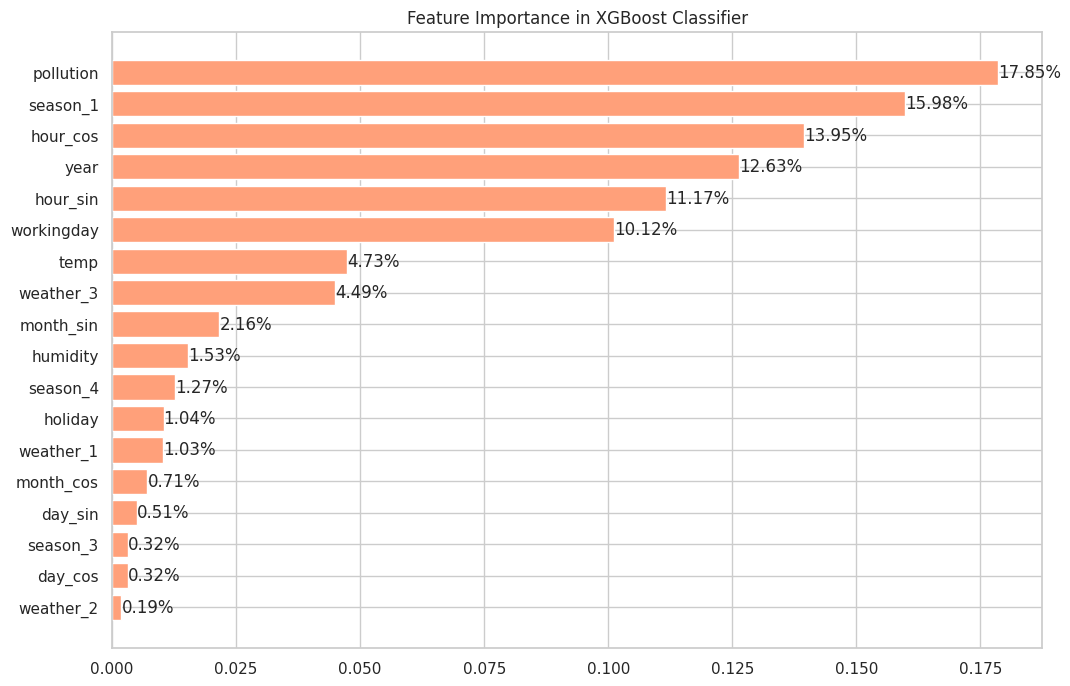

In [ ]:
feature_importance_xgboost_test = model_feature_importance(final_X_train_XGBoost, 'XGBoost', final_models)

#### AdaBoost

In [ ]:
colums_to_keep_AdaBoost = X_data_best_features['AdaBoost'][features_to_remove['AdaBoost']:]
final_X_train_AdaBoost = final_X_train.loc[:, colums_to_keep_AdaBoost]

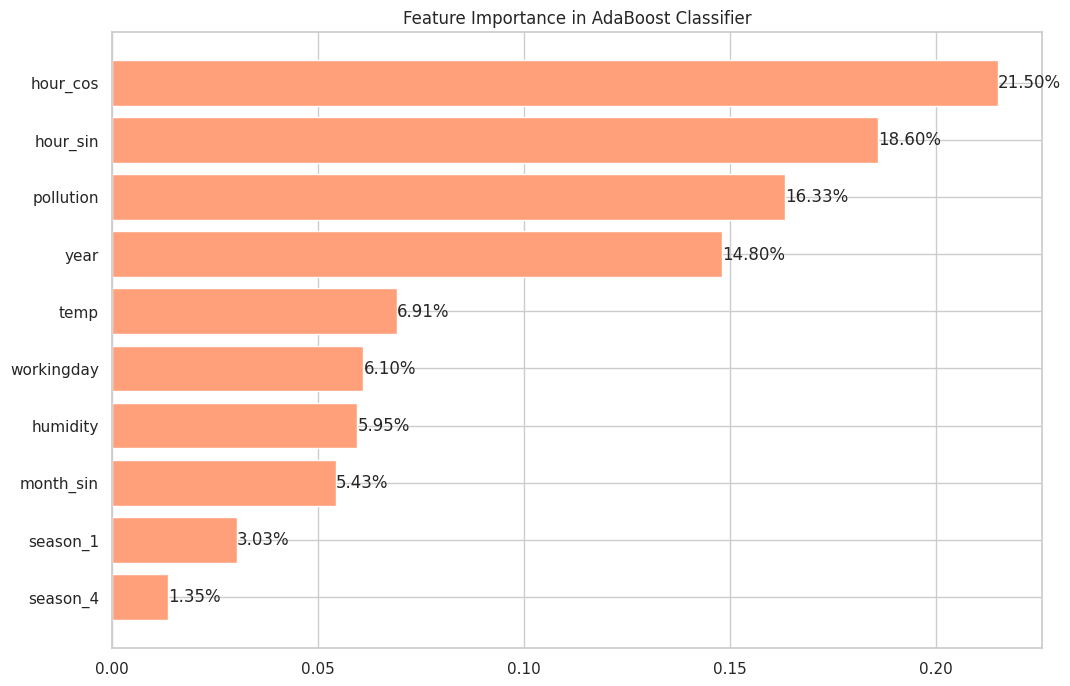

In [ ]:
feature_importance_AdaBoost_test = model_feature_importance(final_X_train_AdaBoost, 'AdaBoost', final_models)

#### Random Forest

In [ ]:
colums_to_keep_RandomForest = X_data_best_features['RandomForest'][features_to_remove['RandomForest']:]
final_X_train_RandomForest = final_X_train.loc[:, colums_to_keep_RandomForest]

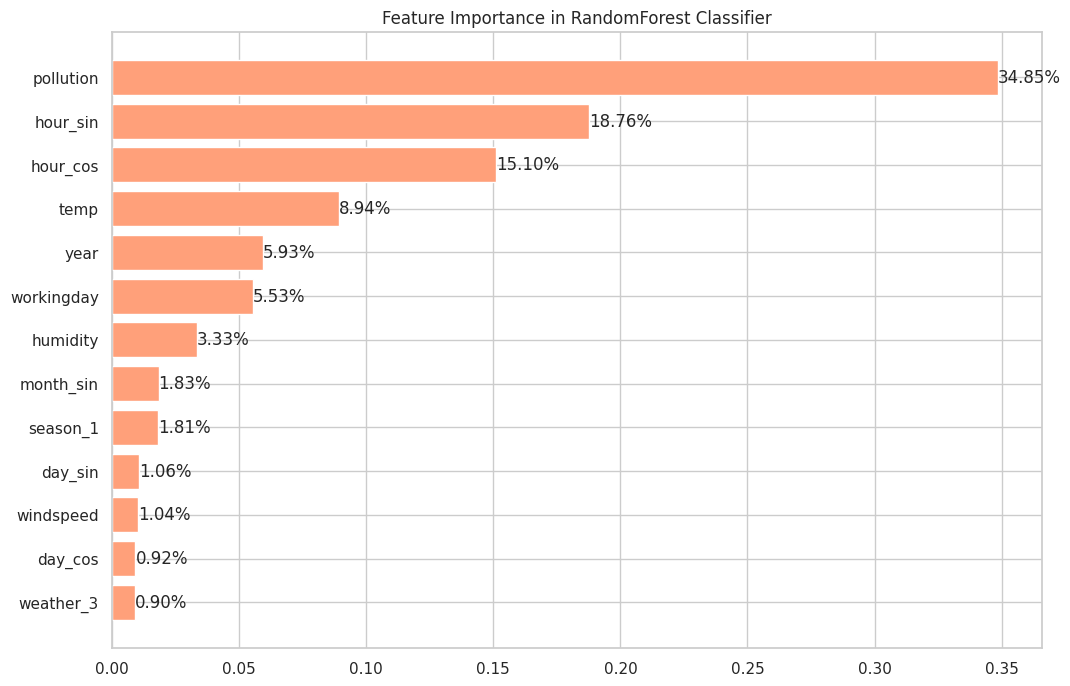

In [ ]:
feature_importance_RandomForest_test = model_feature_importance(final_X_train_RandomForest, 'RandomForest', final_models)

#### Best Features

1. `pollution` - In the EDA part, we observed a high correlation between this feature and the label count $(ρ = 0.6)$. This correlation may explain why it's consistently ranked as one of the top 3 important features in all of our models.
2. `hour_sin` and `hour_cos` - In the EDA part, we explored bike rentals throughout the day and found a significant influence on bike rentals. Notably, during peak hours (8 am and 4-5 pm separately), people tend to rent bikes on their way to and from work. This observation explaines why the hour features are consistently among the top three important features. Specifically, `hour_cos` appeared in all models, while `hour_sin` appeared only in AdaBoost and Random Forest.
3. `season_1` - In the EDA part, specifically in the datetime plot section, we assumed a seasonal-related effect on bike rentals. Our findings demonstrated that bike rentals during January-March were fewer than during May-July for both 2011 and 2012. It makes sense that the `season` feature is split by the winter, given the higher number of unsuitable days for bike riding and fewer bike rentals compared to other periods in the year.

### Generating a CSV file

In this section, we'll create a CSV file containing the following information:
*   Our choice of models
*   The score of our models on the test set in terms of RMSE
*   Our choice of hyperparameters
*   Features dropped
*   New features created
*   Runtime trainining + inference (seconds)
*   Hardware used (GPU/CPU/TPU)
*   Explainability (top 3 features)
















In [ ]:
# Get the best hyperparameters of each model
XGBoost_best_params = list(final_models['XGBoost'].best_params_.items())
AdaBoost_best_params = list(final_models['AdaBoost'].best_params_.items())
RandomForest_best_params = list(final_models['RandomForest'].best_params_.items())

# Get dropped features from feature importance
dropped_features_XGBoost = list(X_data_best_features['XGBoost'][:features_to_remove['XGBoost']])
dropped_features_AdaBoost = list(X_data_best_features['AdaBoost'][:features_to_remove['AdaBoost']])
dropped_features_RandomForest = list(X_data_best_features['RandomForest'][:features_to_remove['RandomForest']])
# Add dropped features from pre-proccesing
features_to_append = ['datetime', 'hour', 'month', 'day', 'atemp', 'sunlight', 'weather', 'season']
dropped_features_XGBoost = features_to_append + dropped_features_XGBoost
dropped_features_AdaBoost = features_to_append + dropped_features_AdaBoost
dropped_features_RandomForest = features_to_append + dropped_features_RandomForest

# Get new features created
features_created = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',  'year', 'season_1', 'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3', 'weather_4']

# Get the best 3 features (feature importance) of each model
best_3_features_XGBoost = list(feature_importance_xgboost_test[-3:])[::-1]
best_3_features_AdaBoost = list(feature_importance_AdaBoost_test[-3:])[::-1]
best_3_features_RandomForest = list(feature_importance_RandomForest_test[-3:])[::-1]

In [ ]:
results = {'model': ['XGBoost', 'AdaBoost', 'Random Forest'],
           'Score (RMSE)': [f'{final_test_scores["XGBoost"]}', f'{final_test_scores["AdaBoost"]}', f'{final_test_scores["RandomForest"]}'],
           'Hyperparams used': [XGBoost_best_params, AdaBoost_best_params, RandomForest_best_params],
           'Features dropped': [dropped_features_XGBoost, dropped_features_AdaBoost, dropped_features_RandomForest],
           'New features created': [features_created, features_created, features_created],
           'Runtime trainining + inference (seconds)': [final_models_time['XGBoost'], final_models_time['AdaBoost'], final_models_time['RandomForest']],
           'Hardware used (GPU/CPU/TPU)': ['CPU', 'CPU', 'CPU'],
           'Explainability (top 3 features)': [best_3_features_XGBoost, best_3_features_AdaBoost, best_3_features_RandomForest]
           }

df_results = pd.DataFrame(results)
df_results

,model,Score (RMSE),Hyperparams used,Features dropped,New features created,Runtime trainining + inference (seconds),Hardware used (GPU/CPU/TPU),Explainability (top 3 features)
0,XGBoost,40.61699569791021,"[(learning_rate, 0.1), (n_estimators, 200), (o...","[datetime, hour, month, day, atemp, sunlight, ...","[hour_sin, hour_cos, month_sin, month_cos, day...",16.60,CPU,"[pollution, season_1, hour_cos]"
1,AdaBoost,102.21273747922194,"[(learning_rate, 0.1), (n_estimators, 200), (r...","[datetime, hour, month, day, atemp, sunlight, ...","[hour_sin, hour_cos, month_sin, month_cos, day...",51.66,CPU,"[hour_cos, hour_sin, pollution]"
2,Random Forest,48.055146986846026,"[(max_depth, 25), (n_estimators, 200)]","[datetime, hour, month, day, atemp, sunlight, ...","[hour_sin, hour_cos, month_sin, month_cos, day...",170.95,CPU,"[pollution, hour_sin, hour_cos]"


In [ ]:
df_results.to_csv(os.path.join(os.getcwd(), 'exercise1.csv'))